# Preparation

### Imports

In [157]:
using NBInclude;
@nbinclude("Rosenbrock_BFGS.ipynb");
@nbinclude("Rosenbrock_GD_Newton.ipynb");
@nbinclude("Visualization.ipynb")

using BenchmarkTools
using StatPlots
using Gadfly

import Cairo, Fontconfig

[1.2417278084798502, 0.4145296698727315, 0.24923687334114852, 0.10534264191669576, 0.08124301477776126, 0.04364572871550838, 0.012456198522351768, 0.00646440418998689, 0.0013745568279172552, 0.00018926958153922408]
[73.22459654444826, 18.608057295680815, 2.3536034268919677, 2.2735965433472742, 1.9900925605320365, 1.7059822282830148, 1.694958372855411, 1.3262378342382721, 1.1295134132585936, 0.9460840981655305, 0.9453690127770393, 0.8831282075625602, 0.6012575356615755, 0.29293966373465485, 0.21786583115350938, 0.15727998025776374, 0.13038864593118707, 0.09683151735287944, 0.060850714157484775, 0.027294582434310766, 0.013161389486259292, 0.005990961548121027, 0.003467922633463421, 0.003094776299646304, 0.00019305050548313544, 1.592152691806592e-5, 4.731754828354007e-7]
function value in iteration 1 for x=[0.038541675569479183, 0.44911775598483294] is 20.96186928282664
function value in iteration 2 for x=[8.862457803287501, -89.07734128984116] is 2.809725007022092e6
function value in ite

# Mean performance of 100 runs - preparation

### Constants

In [158]:
SAMPLES = 100;
ITERS = 10000;
ERROR = 10e-6;
rate = 0.001953125; #GradientDescent
m = 4; #L-BFGS

### Variables

In [159]:
mean_iters = zeros(8);
mean_error = zeros(8);
mean_exec_time = zeros(8);
mean_alloc_bytes = zeros(8);

### Testing mean performance

In [160]:
function rosenbrock_performance(fun, samples, dimensions, max_iters, max_error=0)
    timed_history = []
    for j in 1:samples
        timed = @timed fun(rand(dimensions), max_iters, max_error)
        push!(timed_history, timed)
    end
    
    mean_iters = sum(map(h->h.value[3], timed_history))/samples
    mean_error = sum(map(h->last(h.value[2]), timed_history))/samples
    mean_exec_time = sum(map(h->h.time, timed_history))/samples
    mean_alloc_bytes = sum(map(h->h.bytes, timed_history))/samples
    
    return mean_iters, mean_error, mean_exec_time, mean_alloc_bytes
end

rosenbrock_performance (generic function with 2 methods)

In [161]:
function test_performance(fun, i)
    iters, error, time, bytes = rosenbrock_performance(fun, SAMPLES, DIMENS, ITERS, ERROR)
    mean_iters[i] = iters; mean_error[i] = error; mean_exec_time[i] = time; mean_alloc_bytes[i] = bytes;
    return iters, error, time, bytes
end

test_performance (generic function with 1 method)

### Adapters

In [162]:
gd(x, max_iters, max_error) = rosenbrock_gradient_descent(x, rate, max_iters, max_error)
lbfgs(x, max_iters, max_error) = rosenbrock_LBFGS(x, m, max_iters, max_error)

lbfgs (generic function with 1 method)

# Mean performance of 100 runs for 2 dimens

In [163]:
DIMENS = 2;

### Gradient Descent performance

In [164]:
test_performance(gd, 1)

(5370.41, 9.993038588025879e-6, 0.00444614647, 4.1071912e6)

### Newton's Method performance

In [165]:
test_performance(rosenbrock_newton, 2)

(5.11, 8.282191814372304e-7, 0.00029943323, 258399.68)

### BFGS performance

In [166]:
test_performance(rosenbrock_BFGS, 3)

(10.72, 2.201072618804054e-6, 0.00087133916, 507592.59)

### L-BFGS performance

In [167]:
test_performance(lbfgs, 4)

(10.06, 1.8907651159741084e-6, 0.0009569324600000001, 512364.91)

# Mean performance of 100 runs for 4 dimens

In [168]:
DIMENS = 4;

### Gradient Descent performance

In [169]:
test_performance(gd, 5)

(10000.0, 1.7689024844816206, 0.00966416788, 1.0800448e7)

### Newton's Method performance

In [170]:
test_performance(rosenbrock_newton, 6)

(1511.69, 2.2123862601923708e7, 0.008339991179999999, 1.077551872e7)

### BFGS performance

In [171]:
test_performance(rosenbrock_BFGS, 7)

(20.86, 2.868345847950058e-6, 0.00068238271, 918748.32)

### L-BFGS performance

In [172]:
test_performance(lbfgs, 8)

(23.95, 2.6514930110532437e-6, 0.00107503468, 1.06926352e6)

# Mean performance of 100 runs - visualization

In [173]:
set_default_plot_size(18cm, 13cm)

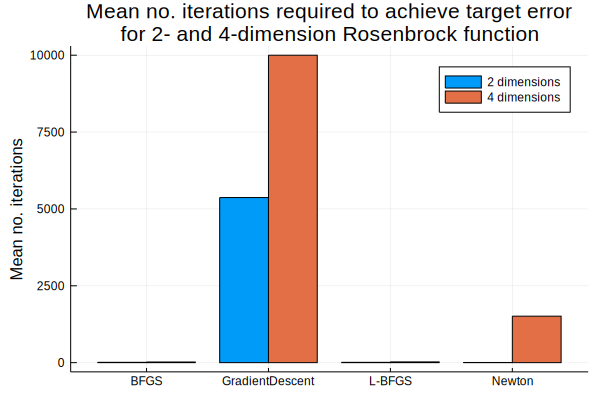

In [174]:
plt = groupedbar(
    repeat(["GradientDescent", "Newton", "BFGS", "L-BFGS"], outer=2), 
    mean_iters,
    group=repeat(["2 dimensions", "4 dimensions"], inner = 4),
    ylabel="Mean no. iterations",
    title="Mean no. iterations required to achieve target error \nfor 2- and 4-dimension Rosenbrock function",
)
savefig(plt, "plots/iterations.pdf")
plt

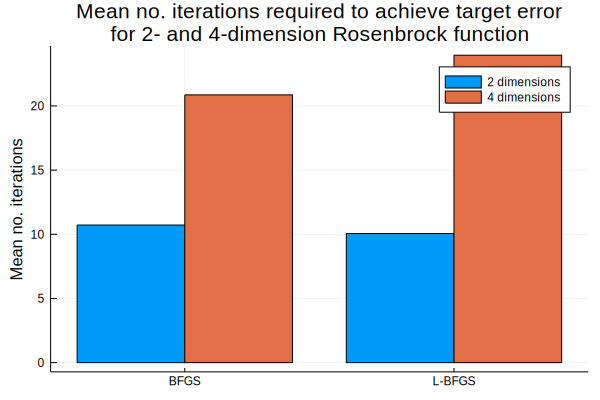

In [175]:
plt = groupedbar(
    repeat(["BFGS", "L-BFGS"], outer=2), 
    [mean_iters[i] for i in [3, 4, 7, 8]],
    group=repeat(["2 dimensions", "4 dimensions"], inner = 2),
    ylabel="Mean no. iterations",
    title="Mean no. iterations required to achieve target error \nfor 2- and 4-dimension Rosenbrock function",
)
savefig(plt, "plots/iterations_bfgs.pdf")
plt

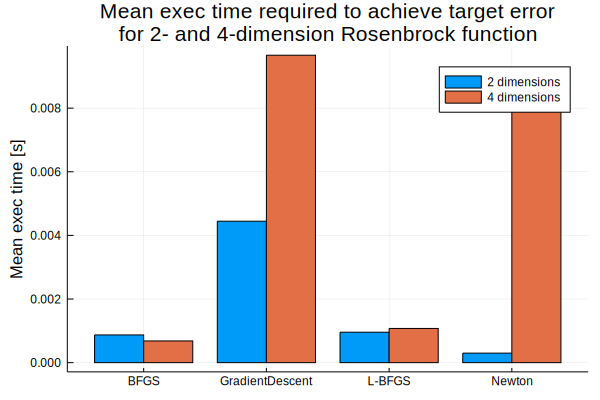

In [176]:
plt = groupedbar(
    repeat(["GradientDescent", "Newton", "BFGS", "L-BFGS"], outer=2), 
    mean_exec_time,
    group=repeat(["2 dimensions", "4 dimensions"], inner = 4),
    ylabel="Mean exec time [s]",
    title="Mean exec time required to achieve target error \nfor 2- and 4-dimension Rosenbrock function",
)
savefig(plt, "plots/time.pdf")
plt

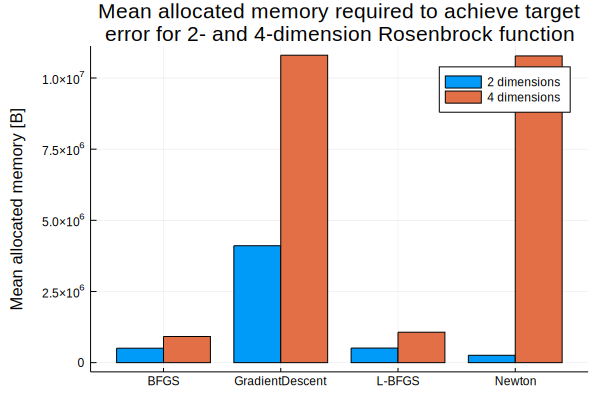

In [177]:
plt = groupedbar(
    repeat(["GradientDescent", "Newton", "BFGS", "L-BFGS"], outer=2), 
    mean_alloc_bytes,
    group=repeat(["2 dimensions", "4 dimensions"], inner = 4),
    ylabel="Mean allocated memory [B]",
    title="Mean allocated memory required to achieve target\nerror for 2- and 4-dimension Rosenbrock function",
)
savefig(plt, "plots/memory.pdf")
plt

# Visualization of Rosenbrock value change - preparation

In [178]:
theme = Theme(
    panel_fill=colorant"gray10",
    default_color=colorant"cyan",
    major_label_color=colorant"black",
    minor_label_color=colorant"black",
    key_label_color=colorant"black",
    key_title_color=colorant"black"
);

# Visualization of Rosenbrock value change for 2 dimens

In [179]:
function contour_cost_multi(
        ax1, ax2, fun, levels, trace1, trace2, trace3, trace4, each, title, xlabel, ylabel )
    set_default_plot_size(18cm, 13cm)    
    plot(
        layer(z = fun, x = ax1, y = ax2, Geom.contour(levels=levels)),
        
        layer( x=trace1[1, 1:each:end], y=trace1[2,1:each:end], Geom.point, Theme(default_color=colorant"lime")),
        layer( x=trace1[1, 1:each:end], y=trace1[2,1:each:end], Geom.line, Theme(default_color=colorant"lime") ),
        
        layer( x=trace2[1, 1:each:end], y=trace2[2,1:each:end], Geom.point, Theme(default_color=colorant"green") ),
        layer( x=trace2[1, 1:each:end], y=trace2[2,1:each:end], Geom.line, Theme(default_color=colorant"green") ),
        
        layer( x=trace3[1, 1:each:end], y=trace3[2,1:each:end], Geom.point, Theme(default_color=colorant"yellow") ),
        layer( x=trace3[1, 1:each:end], y=trace3[2,1:each:end], Geom.line, Theme(default_color=colorant"yellow") ),
        
        layer( x=trace4[1, 1:each:end], y=trace4[2,1:each:end], Geom.point, Theme(default_color=colorant"purple") ),
        layer( x=trace4[1, 1:each:end], y=trace4[2,1:each:end], Geom.line, Theme(default_color=colorant"purple") ),
        
        theme,
        Guide.title(title), Guide.xlabel(xlabel), Guide.ylabel(ylabel),
        Guide.manual_color_key("Legend", ["GradientDescent", "Newton", "BFGS", "L-BFGS"], ["lime", "green", "yellow", "purple"])
    )
end;

In [180]:
DIMENS = 2;
ITERS = 15;

In [181]:
x = rand(DIMENS)
args_gd, values_gd = gd(x, ITERS, ERROR);
args_newton, values_newton = rosenbrock_newton(x, ITERS, ERROR);
args_bfgs, values_bfgs = rosenbrock_BFGS(x, ITERS, ERROR);
args_lbfgs, values_lbfgs = lbfgs(x, ITERS, ERROR);
x

2-element Array{Float64,1}:
 0.7253405039908225
 0.8319489728794505

In [182]:
args_lbfgs

2×7 view(::Array{Float64,2}, :, 1:7) with eltype Float64:
 0.725341  0.860281  0.873733  0.94128   0.951617  0.985006  0.999029
 0.831949  0.739503  0.759083  0.879827  0.90631   0.968741  0.998157

In [183]:
SPAN = 100; LEFT = 0; RIGHT = 1.5
ax = LinRange( LEFT, RIGHT, SPAN );
levels = [LinRange(0, 100, 20)...];

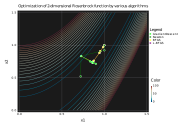

In [184]:
plt = contour_cost_multi(
    ax, ax,
    (x, y) -> rosenbrock( [x, y] ), levels,
    args_gd, args_newton, args_bfgs, args_lbfgs, 1,
    "Optimization of 2-dimensional Rosenbrock function by various algorithms",
    "x1", "x2",
)
draw(PDF("plots/contour_2_multi.pdf"), plt)
plt

In [185]:
test_contour(args, name) = contour_cost(
    ax, ax,
    (x, y) -> rosenbrock( [x, y] ), levels,
    args, 1,
    name,
    "x1", "x2",
)

test_contour (generic function with 1 method)

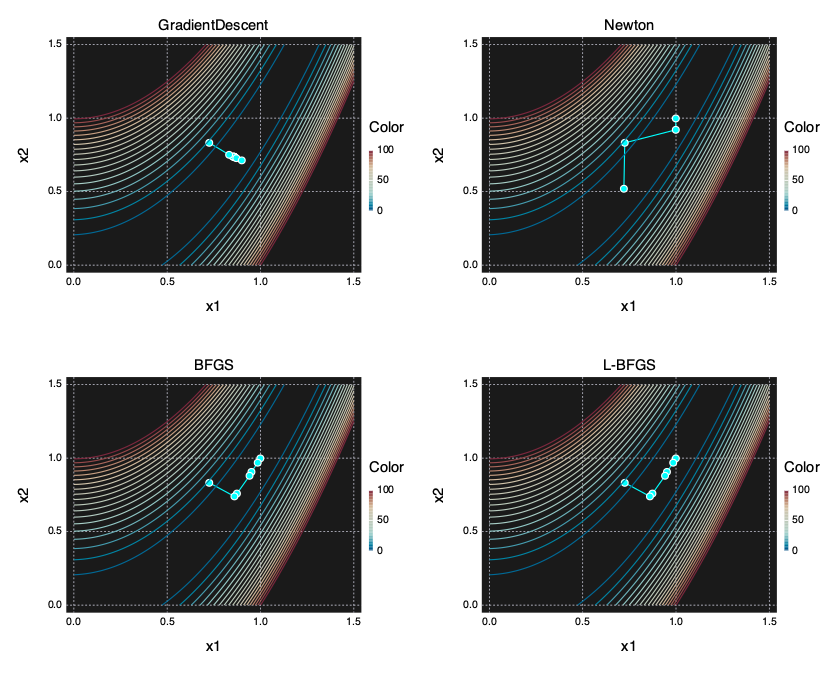

In [186]:
plot_gd = test_contour(args_gd, "GradientDescent")
plot_newton = test_contour(args_newton, "Newton")
plot_bfgs = test_contour(args_bfgs, "BFGS")
plot_lbfgs = test_contour(args_lbfgs, "L-BFGS")
plt = gridstack([plot_gd plot_newton; plot_bfgs plot_lbfgs])
draw(PDF("plots/contour_2_grid.pdf"), plt)
plt

# Visualization of Rosenbrock value change for 4 dimens

In [187]:
function visualize_training_process_multi( iters, y1, y2, y3, y4, title, xlabel, ylabel )
    set_default_plot_size(18cm, 10cm)
    plot(
        layer(x=collect(1:length(y1)), y=y1, Geom.line, Theme(default_color=colorant"lime")),
        layer(x=collect(1:length(y2)), y=y2, Geom.line, Theme(default_color=colorant"green")),
        layer(x=collect(1:length(y3)), y=y3, Geom.line, Theme(default_color=colorant"yellow")),
        layer(x=collect(1:length(y4)), y=y4, Geom.line, Theme(default_color=colorant"purple")),
        theme,
        Guide.title(title), Guide.xlabel(xlabel), Guide.ylabel(ylabel),
        Guide.manual_color_key("Legend", ["GradientDescent", "Newton", "BFGS", "L-BFGS"], ["lime", "green", "yellow", "purple"]),
        Scale.x_log10, Scale.y_log10,
    )
end;

In [188]:
DIMENS = 4;
ITERS = 200;

In [189]:
x = rand(DIMENS)

4-element Array{Float64,1}:
 0.4908594701353195
 0.19213311316644432
 0.619829158325272
 0.9790200620404192

In [190]:
_, values_gd = gd(x, ITERS, ERROR);
_, values_newton = rosenbrock_newton(x, ITERS, ERROR);
_, values_bfgs = rosenbrock_BFGS(x, ITERS, ERROR);
_, values_lbfgs = lbfgs(x, ITERS, ERROR);
x

4-element Array{Float64,1}:
 0.4908594701353195
 0.19213311316644432
 0.619829158325272
 0.9790200620404192

In [191]:
rand(4)

4-element Array{Float64,1}:
 0.8476613710292418
 0.3988083187778291
 0.43962338355802677
 0.46193482420703913

In [192]:
args, vals = rosenbrock_LBFGS(x, 4, 30, 10e-6)
args

4×30 Array{Float64,2}:
 0.490859  0.460631  0.447484  0.462711  …  0.996522  0.997098  0.998083
 0.192133  0.390392  0.544829  0.39557      0.991074  0.994119  0.996906
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0

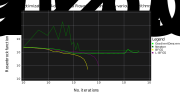

In [193]:
plt = visualize_training_process_multi(ITERS, values_gd, values_newton, values_bfgs, values_lbfgs, 
    "Optimization of 4-dimensional Rosenbrock function by various algorithms",
    "No. iterations", "Rosenbrock function value (y)")
draw(PDF("plots/contour_4_multi.pdf"), plt)
plt